In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import cv2 as cv
from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

import sys 
import os
sys.path.append(os.path.abspath("utils"))
from utils_image import noisy
%config Completer.use_jedi = False

In [2]:
mnist = tf.keras.datasets.mnist

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [6]:
model = tf.keras.Sequential()
model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(28,28,1), padding='same'))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Conv2D(16,kernel_size=3,activation='relu',padding='same'))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Conv2D(8,kernel_size=3,activation='relu', padding='same'))
model.add(MaxPool2D())
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
filepath="weights/model_for_embedding/weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
callbacks_list = [checkpoint, es]

model.fit(x_train, y_train, epochs=10,validation_data=(x_test,y_test), batch_size=128, callbacks=callbacks_list)

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.3647 - acc: 0.8945
Epoch 00001: val_loss improved from inf to 0.33898, saving model to weights/model_for_embedding/weights.best.hdf5
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.3642 - acc: 0.8946 - val_loss: 0.3390 - val_acc: 0.8952
Epoch 2/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.0771 - acc: 0.9762
Epoch 00002: val_loss improved from 0.33898 to 0.06738, saving model to weights/model_for_embedding/weights.best.hdf5
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0771 - acc: 0.9762 - val_loss: 0.0674 - val_acc: 0.9801
Epoch 3/10
59904/60000 [============================>.] - ETA: 0s - loss: 0.0534 - acc: 0.9832
Epoch 00003: val_loss improved from 0.06738 to 0.05182, saving model to weights/model_for_embedding/weights.best.hdf5
60000/60000 [==============================] - 62s 1ms/samp

In [7]:
model.load_weights("weights/model_for_embedding/weights.best.hdf5")

In [8]:
get_embedding = K.function([model.layers[0].input],
                                  [model.layers[9].output])

In [9]:
emb_train = get_embedding([x_train])
emb_test = get_embedding([x_test])

In [10]:
new_x_train = np.array(emb_train[0])
new_y_train = y_train

new_x_test = np.array(emb_test[0])
new_y_test = y_test

In [11]:
model_xgb = XGBClassifier()
model_xgb.fit(new_x_train, new_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
y_pred = model_xgb.predict(new_x_test)
predictions = [round(value) for value in y_pred]

In [13]:
accuracy = accuracy_score(new_y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.99%


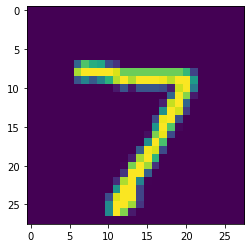

In [18]:
tst_im = np.reshape(x_test[0],(28,28))
plt.imshow(tst_im)

In [21]:
def test_random_noise(img, y, model_xgb, model, noise_type = "gauss", verbose = False, args={}):
    try:
        cnt = args["cnt"]
    except:
        cnt = 2
        
    correct_class = y
    img_noise = noisy(img, noise_type, cnt)
    img_noise =  np.reshape(img_noise,(28,28))
    emb_img_noise = get_embedding(np.array([np.reshape(img_noise, (28,28,1))]))
    noisy_to_predict = emb_img_noise[0][0]
    pred_xgb = model_xgb.predict([noisy_to_predict])
    pred_corr_xgb = True
    if(pred_xgb[0] != correct_class):
        obj = {"type":"XGB", "img":img, "noisy_img":img_noise, "y":y, "pred":pred_xgb[0], "noise": noise_type}
        wrong_samples_xgb.append(obj)
        pred_corr_xgb = False
        if(verbose):
            print("XGB mismatch " + noise_type)
            print(pred_xgb[0])
            plt.imshow(img_noise)
            plt.show()
            
    img_noise_channel = np.reshape(img_noise,(28,28,1))
    pred_single = np.argmax(model.predict(np.array([img_noise_channel]))[0])
    pred_corr_simple = True
    if(pred_single != correct_class):
        obj = {"type":"single", "img":img, "noisy_img":img_noise, "y":y, "pred":pred_single, "noise": noise_type}
        wrong_samples_single.append(obj)
        pred_corr_simple = False
        if(verbose):
            print("SINGLE mismatch" + noise_type)
            print(pred_single)
            plt.imshow(img_noise)
            plt.show()

    return (pred_corr_xgb, pred_corr_simple)
        

In [41]:
wrong_samples_xgb =[]
wrong_samples_single = []
verbose = False
total_xgb = 0
total_single = 0
corr_xgb = 0
corr_single = 0
for sample in range(len(x_test)):
# for sample in range(1000):
    print("SAMPLE ", sample)
    xtst = x_test[sample]
    ytst = y_test[sample]
    for i in range(10):
        total_xgb += 1
        total_single += 1
#         if(np.argmax(model.predict(np.array([xtst])))==ytst):
#             test_random_noise(xtst, ytst, model_xgb, model, "gauss", verbose)     
#             test_random_noise(xtst, ytst, model_xgb, model, "poisson", verbose)
        pred_corr_xgb, pred_corr_simple = test_random_noise(xtst, ytst, model_xgb, model, "gauss", verbose,{"cnt":28})
        if(pred_corr_xgb):
            corr_xgb += 1
        if(pred_corr_simple):
            corr_single +=1

SAMPLE  0
SAMPLE  1
SAMPLE  2
SAMPLE  3
SAMPLE  4
SAMPLE  5
SAMPLE  6
SAMPLE  7
SAMPLE  8
SAMPLE  9
SAMPLE  10
SAMPLE  11
SAMPLE  12
SAMPLE  13
SAMPLE  14
SAMPLE  15
SAMPLE  16
SAMPLE  17
SAMPLE  18
SAMPLE  19
SAMPLE  20
SAMPLE  21
SAMPLE  22
SAMPLE  23
SAMPLE  24
SAMPLE  25
SAMPLE  26
SAMPLE  27
SAMPLE  28
SAMPLE  29
SAMPLE  30
SAMPLE  31
SAMPLE  32
SAMPLE  33
SAMPLE  34
SAMPLE  35
SAMPLE  36
SAMPLE  37
SAMPLE  38
SAMPLE  39
SAMPLE  40
SAMPLE  41
SAMPLE  42
SAMPLE  43
SAMPLE  44
SAMPLE  45
SAMPLE  46
SAMPLE  47
SAMPLE  48
SAMPLE  49
SAMPLE  50
SAMPLE  51
SAMPLE  52
SAMPLE  53
SAMPLE  54
SAMPLE  55
SAMPLE  56
SAMPLE  57
SAMPLE  58
SAMPLE  59
SAMPLE  60
SAMPLE  61
SAMPLE  62
SAMPLE  63
SAMPLE  64
SAMPLE  65
SAMPLE  66
SAMPLE  67
SAMPLE  68
SAMPLE  69
SAMPLE  70
SAMPLE  71
SAMPLE  72
SAMPLE  73
SAMPLE  74
SAMPLE  75
SAMPLE  76
SAMPLE  77
SAMPLE  78
SAMPLE  79
SAMPLE  80
SAMPLE  81
SAMPLE  82
SAMPLE  83
SAMPLE  84
SAMPLE  85
SAMPLE  86
SAMPLE  87
SAMPLE  88
SAMPLE  89
SAMPLE  90
SAMPLE  9

In [ ]:
corr_single/total_single

In [ ]:
corr_xgb/total_xgb

In [30]:
# plt.imshow(wrong_samples_single[0]["img"])
wrong_samples_single[0]["pred"]

8

In [31]:
print("Count of perturbed samples")
print("XGB: ", len(wrong_samples_xgb))
print("single: ", len(wrong_samples_single))

Count of perturbed samples
XGB:  149
single:  87


In [35]:
wrong_samples_xgb =[]
wrong_samples_single = []
verbose = False
for sample in range(len(x_test)):
    print("SAMPLE ", sample)
    xtst = x_test[sample]
    ytst = y_test[sample]
    for i in range(1):
        if(np.argmax(model.predict(np.array([xtst])))==ytst):
            test_random_noise(xtst, ytst, model_xgb, model, "gauss", verbose)     
#             test_random_noise(xtst, ytst, model_xgb, model, "poisson", verbose)
#             test_random_noise(xtst, ytst, model_xgb, model, "1cellgauss", verbose,{"cnt":5})

SAMPLE  0
SAMPLE  1
SAMPLE  2
SAMPLE  3
SAMPLE  4
SAMPLE  5
SAMPLE  6
SAMPLE  7
SAMPLE  8
SAMPLE  9
SAMPLE  10
SAMPLE  11
SAMPLE  12
SAMPLE  13
SAMPLE  14
SAMPLE  15
SAMPLE  16
SAMPLE  17
SAMPLE  18
SAMPLE  19
SAMPLE  20
SAMPLE  21
SAMPLE  22
SAMPLE  23
SAMPLE  24
SAMPLE  25
SAMPLE  26
SAMPLE  27
SAMPLE  28
SAMPLE  29
SAMPLE  30
SAMPLE  31
SAMPLE  32
SAMPLE  33
SAMPLE  34
SAMPLE  35
SAMPLE  36
SAMPLE  37
SAMPLE  38
SAMPLE  39
SAMPLE  40
SAMPLE  41
SAMPLE  42
SAMPLE  43
SAMPLE  44
SAMPLE  45
SAMPLE  46
SAMPLE  47
SAMPLE  48
SAMPLE  49
SAMPLE  50
SAMPLE  51
SAMPLE  52
SAMPLE  53
SAMPLE  54
SAMPLE  55
SAMPLE  56
SAMPLE  57
SAMPLE  58
SAMPLE  59
SAMPLE  60
SAMPLE  61
SAMPLE  62
SAMPLE  63
SAMPLE  64
SAMPLE  65
SAMPLE  66
SAMPLE  67
SAMPLE  68
SAMPLE  69
SAMPLE  70
SAMPLE  71
SAMPLE  72
SAMPLE  73
SAMPLE  74
SAMPLE  75
SAMPLE  76
SAMPLE  77
SAMPLE  78
SAMPLE  79
SAMPLE  80
SAMPLE  81
SAMPLE  82
SAMPLE  83
SAMPLE  84
SAMPLE  85
SAMPLE  86
SAMPLE  87
SAMPLE  88
SAMPLE  89
SAMPLE  90
SAMPLE  9

In [36]:
print("Count of perturbed samples")
print("XGB: ", len(wrong_samples_xgb))
print("single: ", len(wrong_samples_single))

Count of perturbed samples
XGB:  5762
single:  6990


In [33]:
def shownoise(i):
    arr = np.array([wrong_samples_single[i]["img"]])
#     plt.imshow(np.reshape(wrong_samples_single[i]["img"], (28,28)))
#     plt.show()
    lbl = model.predict([arr])

    img_noise = wrong_samples_single[i]["noisy_img"]
    img_noise_channel = np.reshape(img_noise,(28,28,1))
    pred_single = (model.predict(np.array([img_noise_channel])))
#     plt.imshow(np.reshape(wrong_samples_single[i]["noisy_img"], (28,28)))
#     plt.show()
#     print("Correct: ",np.argmax(lbl))
    print("Noise: ",np.argmax(pred_single))

In [67]:
wrong_samples_single[2]["pred"]

{'type': 'single',
 'img': array([[[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ]],
 
        [[0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
         [0.        ],
     

In [34]:
for i in range(100):
    shownoise(i)

Noise:  8
Noise:  8
Noise:  7
Noise:  3
Noise:  2
Noise:  2
Noise:  5
Noise:  0
Noise:  3
Noise:  8
Noise:  7
Noise:  3
Noise:  7
Noise:  7
Noise:  7
Noise:  8
Noise:  4
Noise:  7
Noise:  3
Noise:  2
Noise:  2
Noise:  7
Noise:  8
Noise:  8
Noise:  3
Noise:  7
Noise:  7
Noise:  5
Noise:  2
Noise:  4
Noise:  2
Noise:  3
Noise:  3
Noise:  7
Noise:  1
Noise:  8
Noise:  8
Noise:  0
Noise:  5
Noise:  7
Noise:  4
Noise:  8
Noise:  2
Noise:  7
Noise:  8
Noise:  2
Noise:  9
Noise:  8
Noise:  1
Noise:  5
Noise:  4
Noise:  5
Noise:  2
Noise:  2
Noise:  2
Noise:  2
Noise:  1
Noise:  3
Noise:  2
Noise:  5
Noise:  2
Noise:  8
Noise:  2
Noise:  2
Noise:  2
Noise:  2
Noise:  2
Noise:  3
Noise:  2
Noise:  2
Noise:  4
Noise:  4
Noise:  2
Noise:  5
Noise:  7
Noise:  8
Noise:  2
Noise:  4
Noise:  7
Noise:  7
Noise:  1
Noise:  1
Noise:  8
Noise:  1
Noise:  8
Noise:  7
Noise:  2


IndexError: list index out of range

In [56]:
wrong_samples_single[2]["noisy_img"]

array([[0.00000000e+00, 0.00000000e+00, 2.72690493e-01, 0.00000000e+00,
        8.11192387e-02, 0.00000000e+00, 0.00000000e+00, 1.04698429e-01,
        7.60826242e-02, 0.00000000e+00, 0.00000000e+00, 4.38705870e-01,
        0.00000000e+00, 0.00000000e+00, 2.05137579e-01, 1.98065655e-02,
        2.33997464e-02, 0.00000000e+00, 0.00000000e+00, 2.32470577e-01,
        3.53008935e-01, 2.70756212e-01, 3.34081092e-01, 4.56858891e-02,
        0.00000000e+00, 0.00000000e+00, 7.04489510e-02, 0.00000000e+00],
       [1.99345970e-01, 4.18900516e-01, 0.00000000e+00, 3.73378200e-02,
        4.02132068e-03, 3.06127578e-01, 5.30185027e-02, 4.56948235e-01,
        3.79025199e-02, 3.94063739e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 7.49829682e-02, 5.27110435e-01,
        0.00000000e+00, 1.44509291e-01, 1.28096836e-01, 1.92317548e-02,
        3.44607908e-01, 0.00000000e+00, 1.66792227e-01, 0.00000000e+00,
        1.12457181e-01, 0.00000000e+00, 2.08662368e-01, 4.97806